In [341]:
! pip install tabulate optuna

# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
import itertools
import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import optuna
from joblib import dump
from joblib import load





#### Data Loading and Initial Exploration


In [342]:
# load Train data
train_data = pd.read_csv('../Data/Final_skin_cancer.csv')
train_data.drop_duplicates(inplace=True)
# train_data.drop('drink', axis=1, inplace=True)
# # save data


In [343]:
# train_data.drink.value_counts()

In [344]:
# General information and statistics about the train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 849 entries, 0 to 1703
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   smoke                849 non-null    bool 
 1   age                  849 non-null    int64
 2   pesticide            849 non-null    bool 
 3   gender               849 non-null    int64
 4   skin_cancer_history  849 non-null    bool 
 5   cancer_history       849 non-null    bool 
 6   has_piped_water      849 non-null    bool 
 7   has_sewage_system    849 non-null    bool 
 8   diagnostic           849 non-null    int64
dtypes: bool(6), int64(3)
memory usage: 31.5 KB


#### Feature Selection and Normalization

In [345]:
# Splitting data into features and target
X_train = train_data.drop(['diagnostic'], axis=1)
Y_train = train_data['diagnostic']

In [346]:
# What is happening in this code
# Random Forest Classifier is used to rank the importance of features
# RFE is used to select the most important features
# we will use 5 features in our model
# we will use the selected features to train our model
# we will use the selected features to test our model

# Feature selection using Random Forest Classifier
rfc = DecisionTreeClassifier()  # Using Decision Tree for feature selection
rfe = RFE(rfc, n_features_to_select=7)
rfe = rfe.fit(X_train, Y_train)

# Selecting important features
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]
selected_features

['age',
 'pesticide',
 'gender',
 'skin_cancer_history',
 'cancer_history',
 'has_piped_water',
 'has_sewage_system']

In [347]:
# Train data with selected features
X_train = X_train[selected_features]

In [348]:

# Splitting the dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=42)

#### Decision Tree Model Training and Tuning

In [349]:

# Training a basic Decision Tree Classifier
# Time to train the model
clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  0.0016980171203613281


In [350]:
# Time taken to test the model
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.000978231430053711


In [351]:

# Hyperparameter Tuning for Decision Tree using Optuna
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 5, log=False)
    classifier_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth=dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


In [352]:
# start the optimization process
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

[I 2024-04-04 02:46:18,047] A new study created in memory with name: no-name-01630ae7-6860-4278-abe3-1754b986b44a
[I 2024-04-04 02:46:18,051] Trial 0 finished with value: 0.8274509803921568 and parameters: {'dt_max_depth': 29, 'dt_max_features': 3}. Best is trial 0 with value: 0.8274509803921568.
[I 2024-04-04 02:46:18,053] Trial 1 finished with value: 0.8313725490196079 and parameters: {'dt_max_depth': 12, 'dt_max_features': 4}. Best is trial 1 with value: 0.8313725490196079.
[I 2024-04-04 02:46:18,054] Trial 2 finished with value: 0.8470588235294118 and parameters: {'dt_max_depth': 8, 'dt_max_features': 3}. Best is trial 2 with value: 0.8470588235294118.
[I 2024-04-04 02:46:18,056] Trial 3 finished with value: 0.8196078431372549 and parameters: {'dt_max_depth': 20, 'dt_max_features': 4}. Best is trial 2 with value: 0.8470588235294118.
[I 2024-04-04 02:46:18,058] Trial 4 finished with value: 0.8313725490196079 and parameters: {'dt_max_depth': 28, 'dt_max_features': 5}. Best is trial 2

FrozenTrial(number=7, state=1, values=[0.8941176470588236], datetime_start=datetime.datetime(2024, 4, 4, 2, 46, 18, 62562), datetime_complete=datetime.datetime(2024, 4, 4, 2, 46, 18, 63942), params={'dt_max_depth': 2, 'dt_max_features': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=5, log=False, low=2, step=1)}, trial_id=7, value=None)


In [353]:

# Training the Decision Tree model with the best parameters
# dt = DecisionTreeClassifier(max_features=study_dt.best_trial.params['dt_max_features'], max_depth=study_dt.best_trial.params['dt_max_depth'])
from sklearn.ensemble import ExtraTreesClassifier

dt = ExtraTreesClassifier()
dt.fit(x_train, y_train)

ExtraTreesClassifier()

#### Model Evaluation

In [354]:
# Model Performance Metrics
dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)
print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")


Train Score: 0.9781144781144782
Test Score: 0.8392156862745098


In [355]:

# Cross-Validation why we use cross-validation?
# Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
# The goal of cross-validation is to test the model’s ability to predict new data that was not used in estimating it
# we will use cross-validation to evaluate the performance of our model
# we will use 10 folds for cross-validation
# we will use the accuracy metric to evaluate the performance of our model

scores = cross_val_score(dt, x_train, y_train, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(scores)}")

Cross-Validation Accuracy: 0.868813559322034


In [356]:
# Confusion Matrix and Classification Report why we use these metrics?
# Confusion matrix is used to evaluate the performance of a classification model
# Classification report is used to measure the quality of predictions from a classification algorithm
y_pred = dt.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

[[ 21  23]
 [ 18 193]]
              precision    recall  f1-score   support

           0       0.54      0.48      0.51        44
           1       0.89      0.91      0.90       211

    accuracy                           0.84       255
   macro avg       0.72      0.70      0.71       255
weighted avg       0.83      0.84      0.84       255

F1 Score: 0.9039812646370023


#### Summary Table

In [357]:

# Creating a summary table of model performance
data = [["Decision Tree", dt_train, dt_test, np.mean(scores), f1]]
col_names = ["Model", "Train Score", "Test Score", "CV Accuracy", "F1 Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤════════════╕
│ Model         │   Train Score │   Test Score │   CV Accuracy │   F1 Score │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪════════════╡
│ Decision Tree │      0.978114 │     0.839216 │      0.868814 │   0.903981 │
╘═══════════════╧═══════════════╧══════════════╧═══════════════╧════════════╛


#### Saving the model

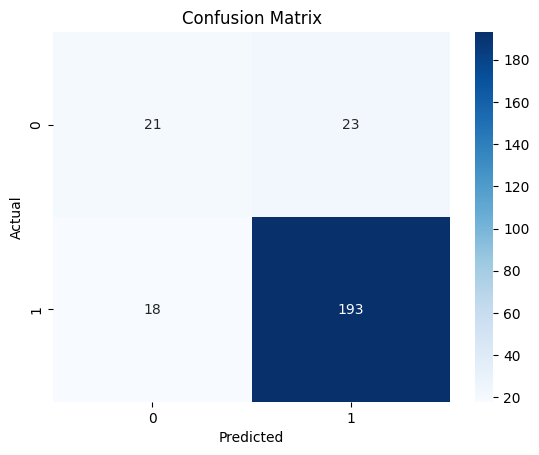

In [358]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [359]:
# # Save the model to a file
# model_filename = 'decision_tree_model.joblib'
# dump(dt, model_filename)
# print(f"Model saved to {model_filename}")

#### Load the model

In [360]:
# # Load the model from the file
# loaded_model = load(model_filename)
# print("Model loaded successfully")